In [1]:
# imports

import getpass
import matplotlib as mpl
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import pycmap
import seaborn as sns
import skimage.io as sio
import warnings

from IPython.display import Image
from matplotlib import pyplot as plt
from numpy import pi, sin, cos
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

# stop showing SettingWithCopyWarning
pd.options.mode.chained_assignment = None


In [2]:
# cmap api key: this is needed to interface with Simons CMAP (cell 7)
# if you don't have a CMAP API key, you can generate one at https://simonscmap.com/apikeymanagement)

api_key = getpass.getpass('Enter your CMAP API token here: ')
print('CMAP API key received.')


Enter your CMAP API token here:  ········


CMAP API key received.


In [3]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mpl.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [4]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 100

grad_hexes = ['#4F1DD7', '#63B9FF', '#0AFFDE']
grad_cmap = get_continuous_cmap(grad_hexes)
grad_cmap.set_bad(color=line_color)

annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}


# Import data

In [5]:
# read in sample metadata

data_path = Path('../../data')
out_dir = Path('../../figures/2-mapping/')
sample_df = pd.read_csv(data_path / 'metadata/sample_metadata_merged.csv')
# sample_df['Datetime'] = pd.to_datetime(sample_df['Datetime'], format='%m/%d/%y %H:%M')
sample_df['Datetime'] = pd.to_datetime(sample_df['Datetime'])

sample_df


,SampleName,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Replicates,Experiment,Condition,Treatment,Timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,2017-06-06 06:56:00,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,1,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,2017-06-09 05:30:00,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,3,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,2017-06-10 09:34:00,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,3,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,2017-06-11 05:50:00,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,3,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,2019-04-16 08:00:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,2019-04-22 06:44:00,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,2,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,2019-04-24 05:57:00,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,2019-04-24 14:47:00,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,2,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,2019-04-25 06:01:00,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,3,NaN,NaN,NaN,NaN


# Plot sample distributions

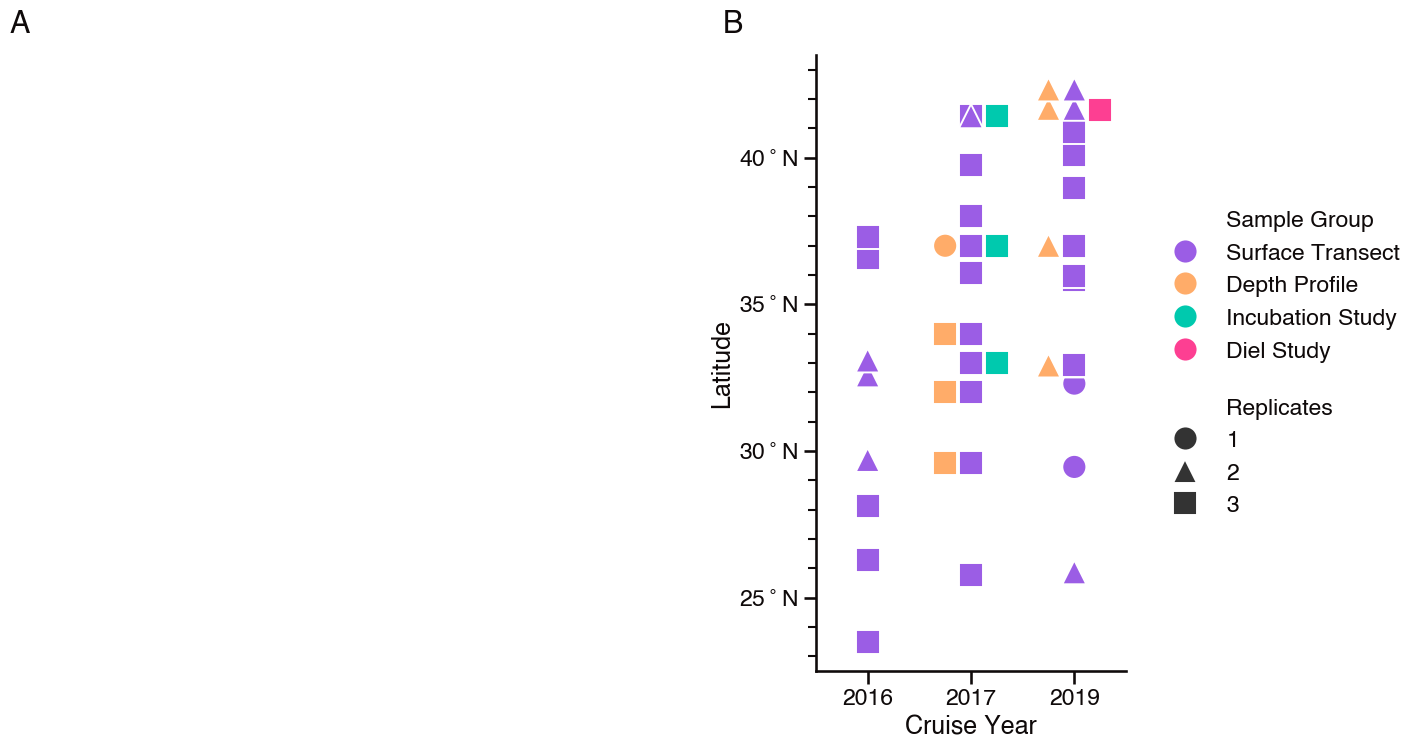

In [6]:
# Plot all sample summary

plot_df = sample_df.copy()
# reassign surface transect samples to other sample groups
# new_sample_groups = {
#     'G2.REXP1.NS.Ctrl.T0': 'incubations', 
#     'G2.SURF.NS.S11C1.15m': 'depth profiles', 
#     'G2.REXP2.NS.Ctrl.T0': 'incubations', 
#     'G2.SURF.NS.S15C1.15m': 'depth profiles', 
#     'G2.SURF.NS.S16C1.15m': 'incubations', 
#     'G2.SURF.NS.S17C1.15m': 'depth profiles', 
#     'G2.SURF.NS.S18C1.15m': 'depth profiles', 
#     'G3.DEPTH.NS.S4C6.15m': 'depth profiles', 
#     'G3.DEPTH.NS.S5C8.15m': 'depth profiles', 
#     'G3.DEPTH.NS.S6C7.15m': 'depth profiles', 
#     'G3.DEPTH.NS.S8C2.15m': 'depth profiles'
# }
# plot_df.loc[plot_df.SampleName.isin(new_sample_groups.keys()), 'SampleGroup'] = plot_df[
#     plot_df.SampleName.isin(new_sample_groups.keys())]['SampleName'].map(new_sample_groups)
# re-map sample group names
plot_df['Sample Group'] = plot_df['SampleGroup'].map({
    'surface transect': 'Surface Transect', 
    'depth profiles': 'Depth Profile', 
    'incubations': 'Incubation Study', 
    'diel study': 'Diel Study'
})
# replace diel longitude with the mean of all samples
plot_df.loc[plot_df.SampleGroup.eq('diel study'), 'Latitude'] = plot_df[plot_df.SampleGroup.eq('diel study')].Latitude.mean()
# replace G2 T0 incubation longitude with that of other incubation samples
plot_df.loc[plot_df.SampleName.eq('G2.SURF.NS.S16C1.15m'), 'Latitude'] = 33
# aggregate by year, latitude, and sample group
plot_df = plot_df.groupby(['Year', 'Latitude', 'Sample Group']).agg(
    Replicates=('Replicates', 'max'), 
    Samples=('Replicates', 'sum')
).reset_index()
# make indices for scatterplot
plot_df['Index'] = plot_df['Year'].map({2016: 1., 2017: 3., 2019: 5.})
plot_df.loc[plot_df['Sample Group'].isin(['Depth Profile']), 'Index'] -= .5
plot_df.loc[plot_df['Sample Group'].isin(['Incubation Study', 'Diel Study']), 'Index'] += .5

# hackey solution to make legend more readable
plot_df = plot_df.rename(columns={'Replicates': '\nReplicates'})

# plot sampling sites
bounds = (23, 43)
fig, axis = plt.subplots(figsize=(4, 8))
sns.scatterplot(
    x='Index', 
    y='Latitude', 
    hue='Sample Group', 
    style='\nReplicates', 
    # size='Samples', 
    s=300, 
    markers=['o', '^', 's'], 
    data=plot_df, 
    ax=axis
)
# legends and labels
axis.legend(loc='center left', bbox_to_anchor=(1.05, 0.5));
axis.set_xticks([1, 3, 5], [2016, 2017, 2019])
axis.set_yticks(np.arange(bounds[0]+2, bounds[1], 5), [f'{l}$^\circ$N' for l in np.arange(bounds[0]+2, bounds[1], 5)]);
axis.set_yticks(np.arange(bounds[0], bounds[1]+1, 1), minor=True);
axis.set(xlabel='Cruise Year', ylabel='Latitude', xlim=(0, 6), ylim=(bounds[0]-0.5, bounds[1]+0.5));
# label subplots
axis.annotate('A', xy=(-2.6, 1.05), **annot_kwgs)
axis.annotate('B', xy=(-0.3, 1.05), **annot_kwgs)

fig.savefig(out_dir / 'sample-site-summary.png', bbox_inches='tight', dpi=300)
    

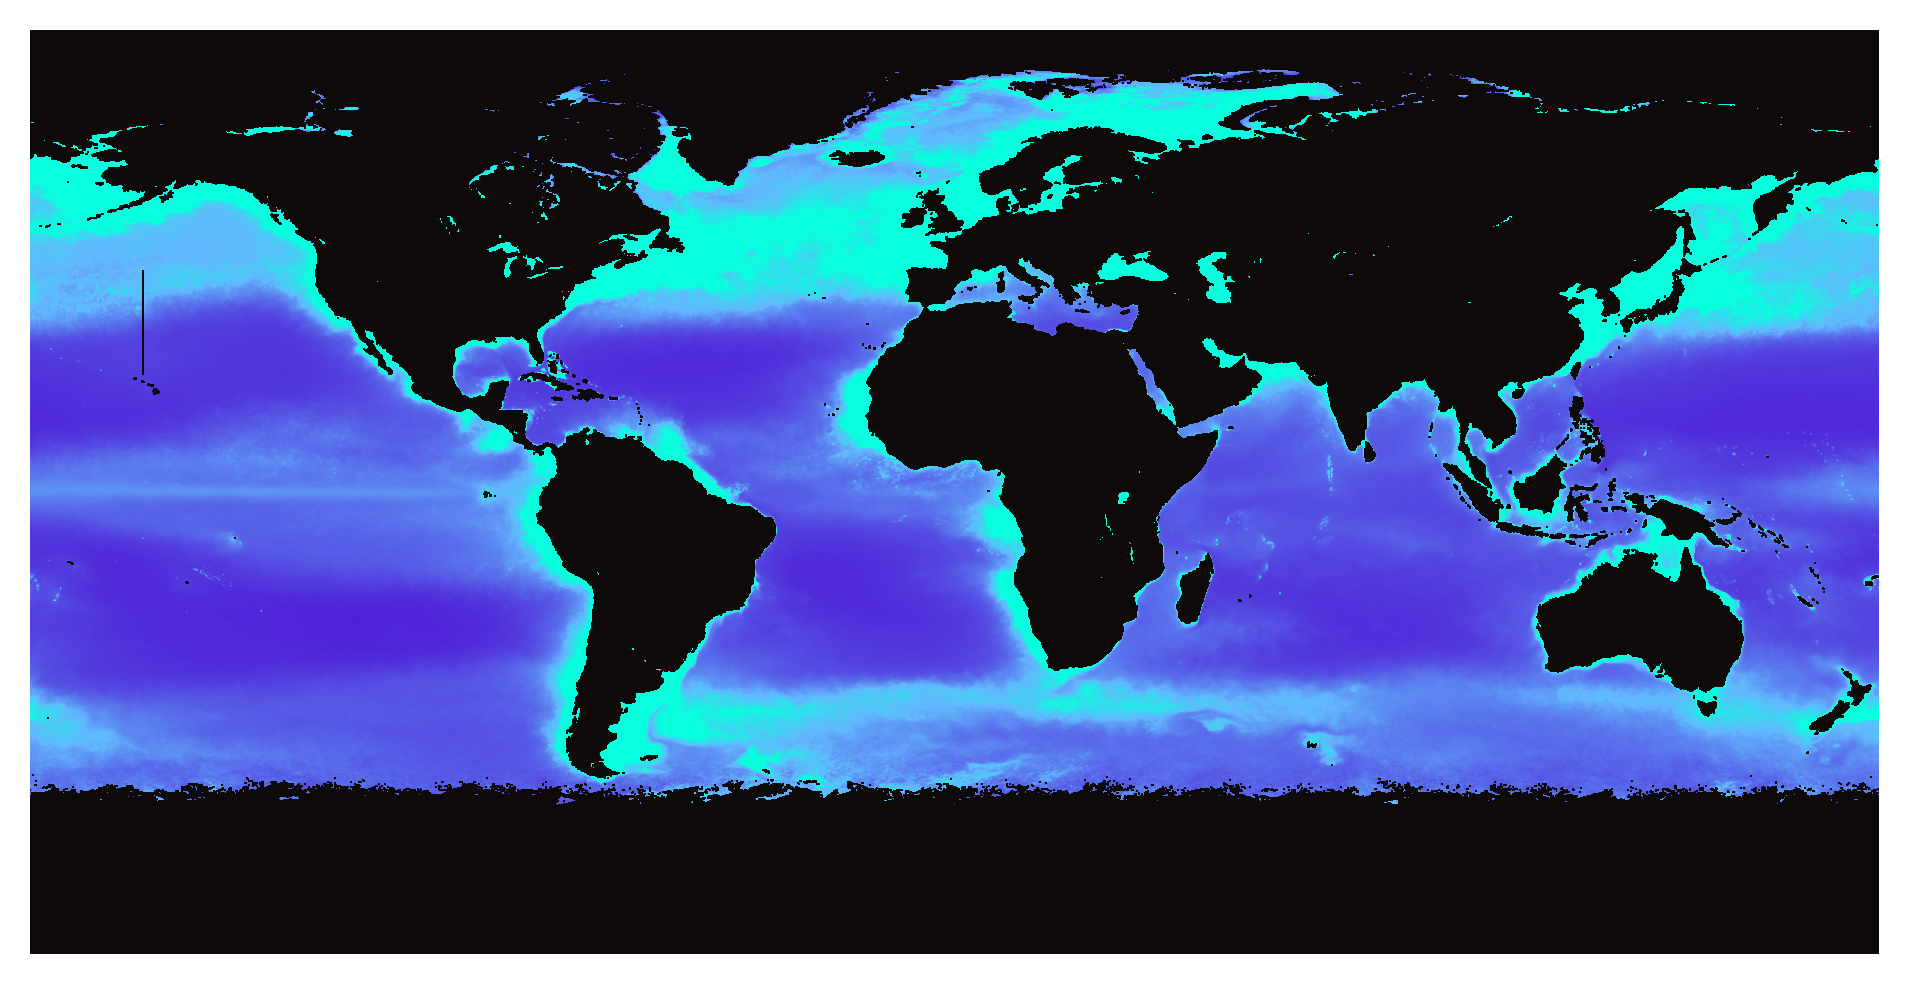

In [7]:
# plot chlorophyll climatology
# code adapted from climatology visualization example on cmap website: https://simonscmap.com/documentation 

# cmap api
api = pycmap.API(token=api_key)

# fetch chlorophyll data from cmap
chl_df = api.climatology(
    table='tblModis_CHL_cl1',
    variable='chlor_a',
    period='month',
    periodVal=4,
    lat1=-90,
    lat2=90,
    lon1=-180,
    lon2=180,
    depth1=0,
    depth2=0
)

# mark off cruise track
chl_df.loc[chl_df.lat.between(23, 43) & chl_df.lon.between(-158.1, -157.9), 'chlor_a'] = np.nan

# set image parameters
lat = chl_df.lat.unique()
lon = chl_df.lon.unique()
shape = (len(lat), len(lon))
dpi = 300
data_df = chl_df.chlor_a.values.reshape(shape)

# make image
fig, axis = plt.subplots(figsize=(8, 4), dpi=dpi)
axis.imshow(data_df, extent=[np.min(lon), np.max(lon), np.min(lat), np.max(lat)], cmap=grad_cmap, origin='lower', vmin=0, vmax=0.5)
axis.axis('off')

# save image
fig.savefig(out_dir / 'chlorophyll-climatology.png', bbox_inches='tight', dpi=dpi, pad_inches=0)


In [8]:
# code for mapping 2d image to 3d surface
# adapted from https://chart-studio.plotly.com/~empet/16132/color-image-quantization-and-tex/#/

def image2zvals(img,  n_colors=64, n_training_pixels=800, rngs = 123): 
    # Image color quantization
    # img - np.ndarray of shape (m, n, 3) or (m, n, 4)
    # n_colors: int,  number of colors for color quantization
    # n_training_pixels: int, the number of image pixels to fit a KMeans instance to them
    # returns the array of z_values for the heatmap representation, and a plotly colorscale
   
    if img.ndim != 3:
        raise ValueError(f"Your image does not appear to  be a color image. It's shape is  {img.shape}")
    rows, cols, d = img.shape
    if d < 3:
        raise ValueError(f"A color image should have the shape (m, n, d), d=3 or 4. Your  d = {d}") 
        
    range0 = img[:, :, 0].max() - img[:, :, 0].min()
    if range0 > 1: #normalize the img values
        img = np.clip(img.astype(float)/255, 0, 1)
        
    observations = img[:, :, :3].reshape(rows*cols, 3)
    training_pixels = shuffle(observations, random_state=rngs)[:n_training_pixels]
    model = KMeans(n_clusters=n_colors, random_state=rngs, n_init=10).fit(training_pixels)
    
    codebook = model.cluster_centers_
    indices = model.predict(observations)
    z_vals = indices.astype(float) / (n_colors-1) #normalization (i.e. map indices to  [0,1])
    z_vals = z_vals.reshape(rows, cols)
    # define the Plotly colorscale with n_colors entries    
    scale = np.linspace(0, 1, n_colors)
    colors = (codebook*255).astype(np.uint8)
    pl_colorscale = [[sv, f'rgb{tuple(color)}'] for sv, color in zip(scale, colors)]
      
    # Reshape z_vals  to  img.shape[:2]
    return z_vals.reshape(rows, cols), pl_colorscale

def regular_tri(rows, cols):
    #define triangles for a np.meshgrid(np.linspace(a, b, cols), np.linspace(c,d, rows))
    triangles = []
    for i in range(rows-1):
        for j in range(cols-1):
            k = j+i*cols
            triangles.extend([[k,  k+cols, k+1+cols], [k, k+1+cols, k+1]])
    return np.array(triangles) 
       
def mesh_data(img, n_colors=32, n_training_pixels=800):
    rows, cols, _ = img.shape
    z_data, pl_colorscale = image2zvals(img, n_colors=n_colors, n_training_pixels=n_training_pixels)
    triangles = regular_tri(rows, cols) 
    I, J, K = triangles.T
    zc = z_data.flatten()[triangles] 
    tri_color_intensity = [zc[k][2] if k%2 else zc[k][1] for k in range(len(zc))]  
    return I, J, K, tri_color_intensity, pl_colorscale

def sphere(rows, cols):
    u, v = np.meshgrid(np.linspace(0, 2*pi, cols), np.linspace(-pi/2, pi/2, rows))
    return cos(u)*cos(v), sin(u)*cos(v), sin(v)

scene_style = dict(scene=dict(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False),
                   scene_aspectmode="data")


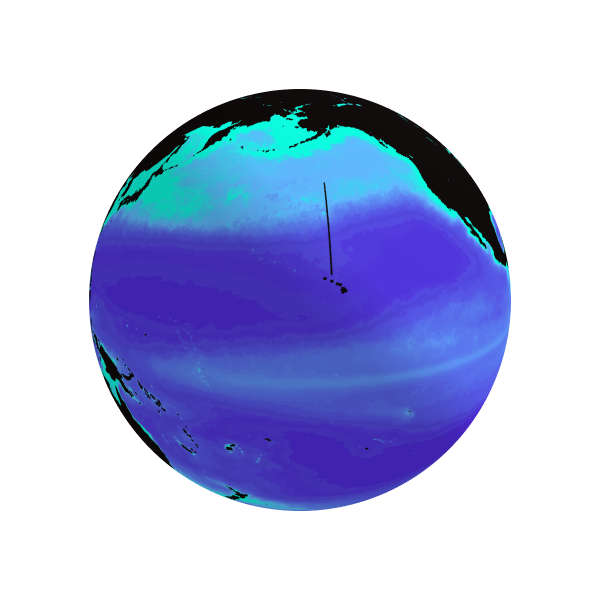

In [9]:
# map 2d climatology onto 3d surface
# adapted from https://chart-studio.plotly.com/~empet/16132/color-image-quantization-and-tex/#/

img = sio.imread(out_dir / 'chlorophyll-climatology.png')

r, c, _ = img.shape
x, y, z = sphere(r, c)
I, J, K, tri_color_intensity, pl_colorscale = mesh_data(img, n_colors=32, n_training_pixels=10000) 
sphere_fig = go.Figure()
sphere_fig.add_mesh3d(x=x.flatten(), y=y.flatten(), z=np.flipud(z).flatten(),  
                            i=I, j=J, k=K, intensity=tri_color_intensity, intensitymode='cell', 
                            colorscale=pl_colorscale, showscale=False);

sphere_fig.update_layout(width=600, height=600,
                  margin=dict(t=10, r=10, b=10, l=10),
                  scene_camera_eye=dict(x=1.5, y=0.4, z=.5),
                  **scene_style)

# save image
sphere_fig.write_image(out_dir / 'globe-chlorophyll-climatology.png', scale=3)

# render inline non-interactively
img_bytes = sphere_fig.to_image(format='png')
Image(img_bytes)
